In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,GRU,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow as tf

2023-11-13 19:34:16.729802: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 19:34:16.755359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 19:34:16.755388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 19:34:16.755402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 19:34:16.763520: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [17]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


In [18]:
def model_builder(hp):
    model=Sequential()
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model.add(Bidirectional(LSTM(hp_units,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')

    return model

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     project_name='lstm_tuning',
                     max_trials=100)

Reloading Tuner from ./lstm_tuning/tuner0.json


In [20]:
tuner.search(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[stop_early])


In [21]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first 
layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first 
layer is 80.



Epoch 1/1000


2023-11-13 19:34:18.175758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 19:34:18.230277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 19:34:18.230317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 19:34:18.232812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 19:34:18.232856: I tensorflow/compile

4/4 [==============================] - 2s 77ms/step - loss: 0.0416 - val_loss: 0.0098
Epoch 2/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0038 - val_loss: 0.0079
Epoch 3/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0167 - val_loss: 0.0035
Epoch 4/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 5/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0031 - val_loss: 0.0128
Epoch 6/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0034 - val_loss: 0.0091
Epoch 7/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 8/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 11/1000
4/4 [===

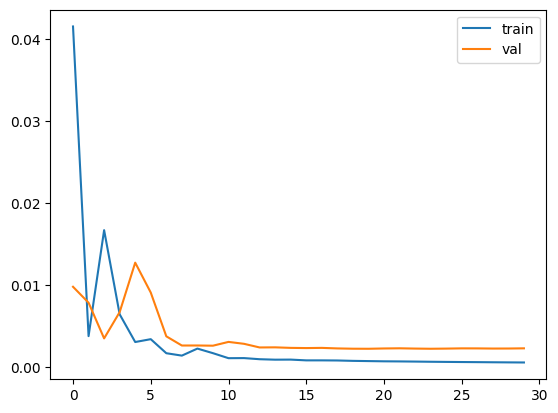

4/4 [==============================] - 0s 4ms/step
mae: 2.3135009080607096


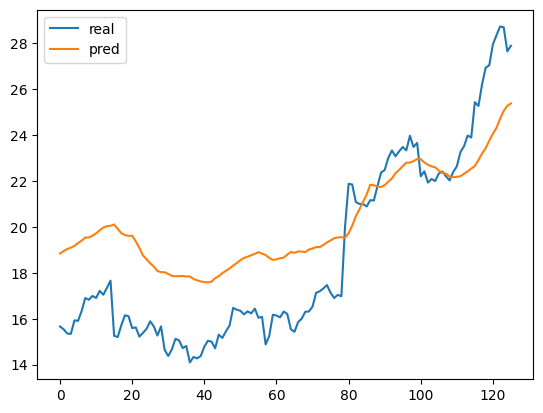

Epoch 1/1000
7/7 [==============================] - 1s 48ms/step - loss: 0.0120 - val_loss: 0.0215
Epoch 2/1000
7/7 [==============================] - 0s 31ms/step - loss: 0.0178 - val_loss: 0.0043
Epoch 3/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.0101 - val_loss: 0.0058
Epoch 4/1000
7/7 [==============================] - 0s 29ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 5/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.0030 - val_loss: 0.0074
Epoch 6/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 7/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 8/1000
7/7 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 9/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 10/1000
7/7 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 11/

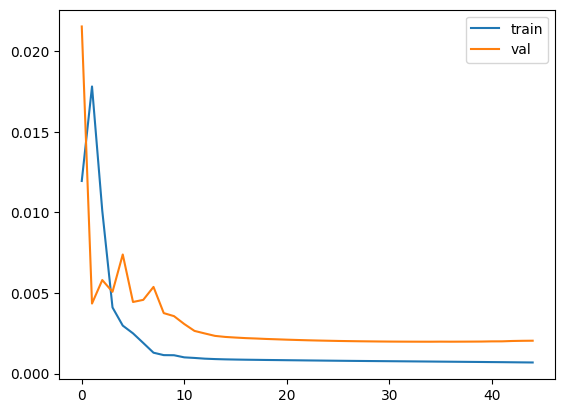

4/4 [==============================] - 0s 3ms/step
mae: 2.60795322628542


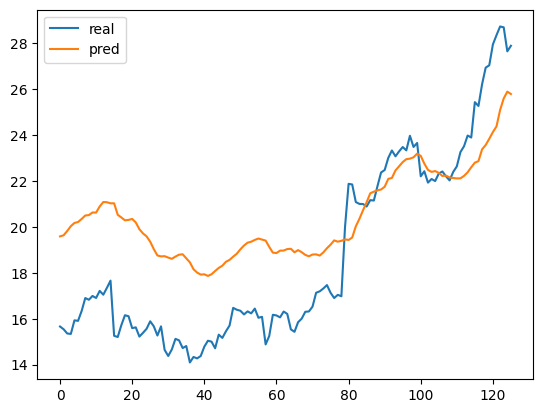

Epoch 1/1000
10/10 [==============================] - 1s 42ms/step - loss: 0.0294 - val_loss: 0.0044
Epoch 2/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 3/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 6/1000
10/10 [==============================] - 0s 29ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 9/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0010 - val_lo

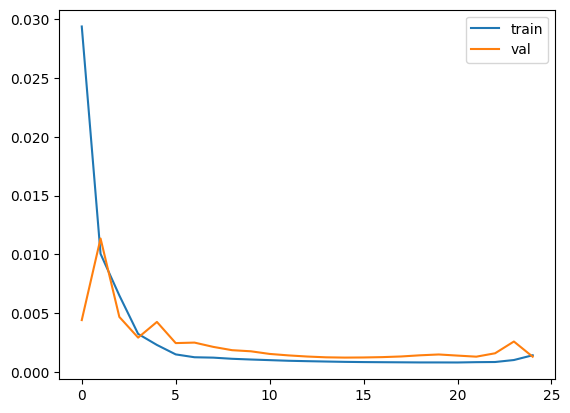

4/4 [==============================] - 0s 4ms/step
mae: 1.606346269806393


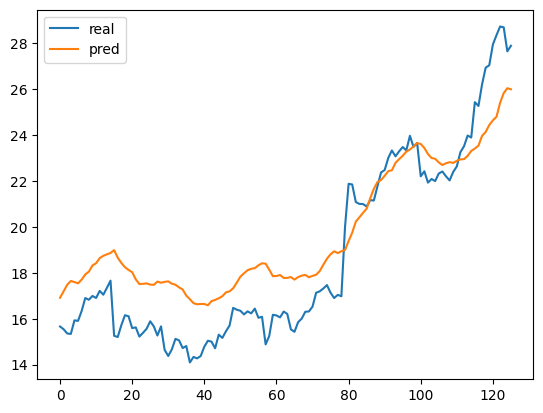

Epoch 1/1000
13/13 [==============================] - 2s 38ms/step - loss: 0.0143 - val_loss: 0.0054
Epoch 2/1000
13/13 [==============================] - 0s 28ms/step - loss: 0.0145 - val_loss: 0.0029
Epoch 3/1000
13/13 [==============================] - 0s 27ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 4/1000
13/13 [==============================] - 0s 26ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/1000
13/13 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/1000
13/13 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/1000
13/13 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/1000
13/13 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/1000
13/13 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/1000
13/13 [==============================] - 0s 25ms/step - loss: 0.0012 - val_lo

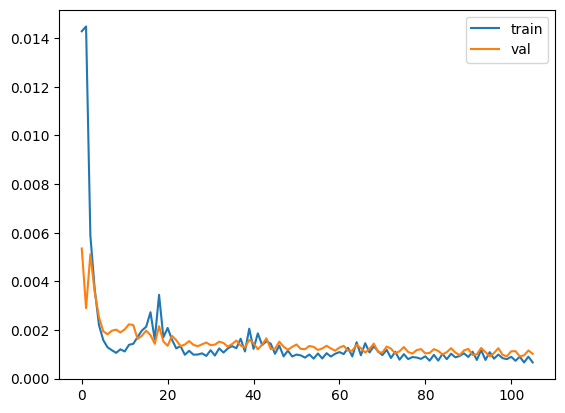

4/4 [==============================] - 0s 3ms/step
mae: 1.2627371260356604


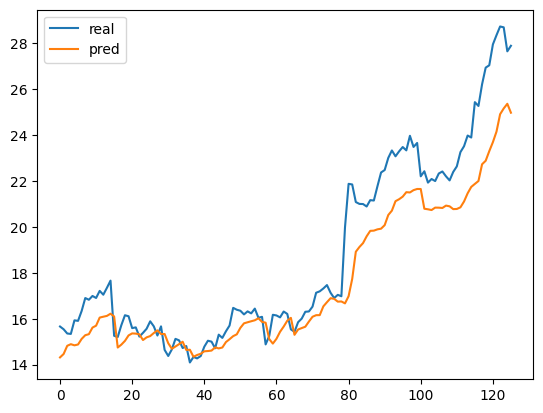

Epoch 1/1000
17/17 [==============================] - 2s 34ms/step - loss: 0.0202 - val_loss: 0.0692
Epoch 2/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.0122 - val_loss: 0.0163
Epoch 3/1000
17/17 [==============================] - 0s 28ms/step - loss: 0.0076 - val_loss: 0.0371
Epoch 4/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.0139
Epoch 5/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 6/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0079
Epoch 7/1000
17/17 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0108
Epoch 8/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 9/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 10/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.0023 - val_lo

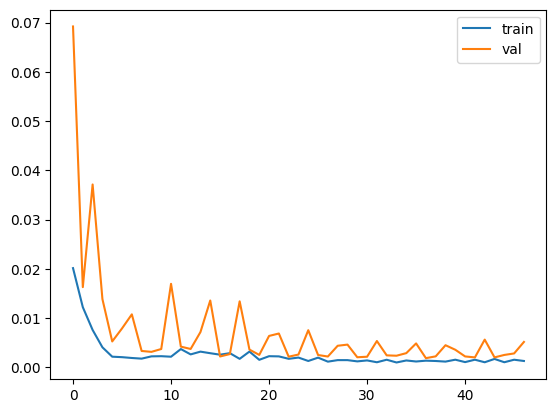

4/4 [==============================] - 0s 3ms/step
mae: 1.3992826608770463


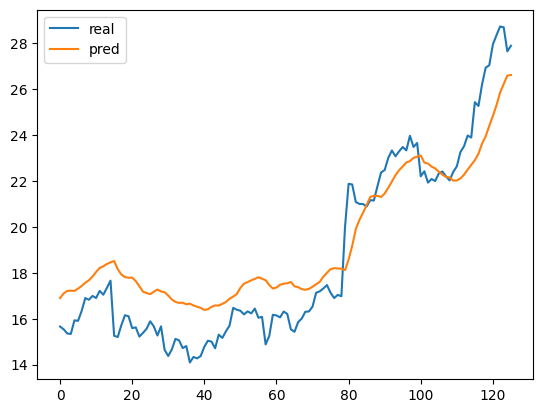

Epoch 1/1000
20/20 [==============================] - 2s 31ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 2/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.0214 - val_loss: 0.0058
Epoch 3/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.0086 - val_loss: 0.0033
Epoch 4/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.0121 - val_loss: 0.0128
Epoch 5/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 6/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 7/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 8/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 9/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 10/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.0012 - val_lo

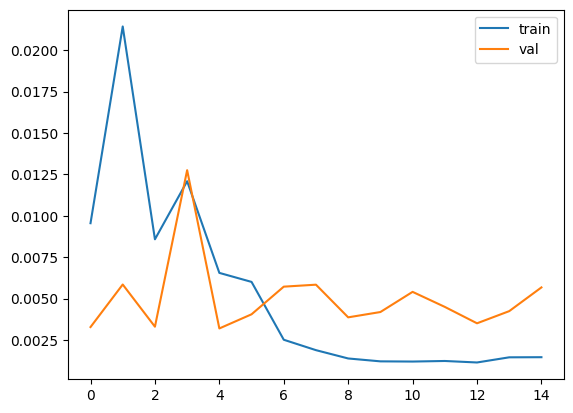

4/4 [==============================] - 0s 3ms/step
mae: 2.7186818393913152


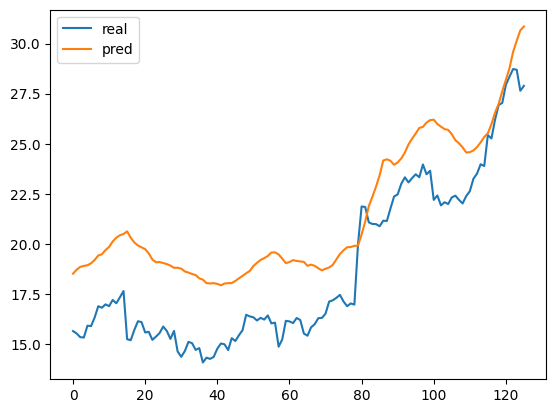

Epoch 1/1000
23/23 [==============================] - 2s 32ms/step - loss: 0.0537 - val_loss: 0.0039
Epoch 2/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.0117 - val_loss: 0.0338
Epoch 3/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 4/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 5/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0084 - val_loss: 0.0203
Epoch 6/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0184 - val_loss: 0.0029
Epoch 7/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0096 - val_loss: 0.0041
Epoch 8/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0066 - val_loss: 0.0124
Epoch 9/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0034 - val_loss: 0.0133
Epoch 10/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0043 - val_lo

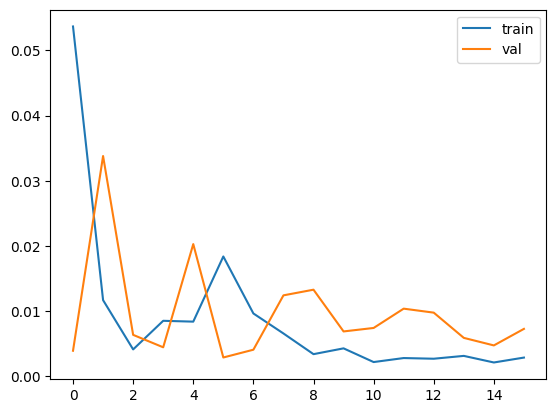

4/4 [==============================] - 0s 4ms/step
mae: 1.3625434265843954


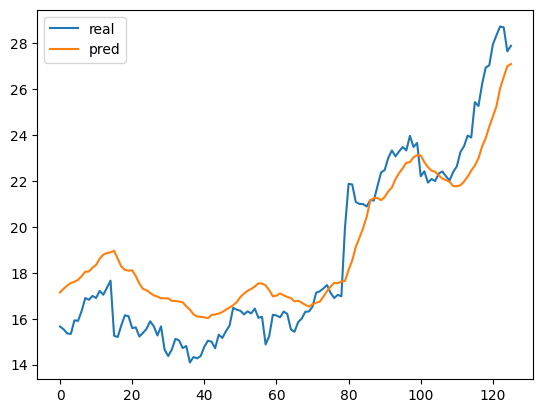

Epoch 1/1000
26/26 [==============================] - 2s 31ms/step - loss: 0.0365 - val_loss: 0.0240
Epoch 2/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0464 - val_loss: 0.0259
Epoch 3/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0340 - val_loss: 0.0047
Epoch 4/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0096 - val_loss: 0.0148
Epoch 5/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0055 - val_loss: 0.0126
Epoch 6/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 7/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 8/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 9/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 10/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0018 - val_lo

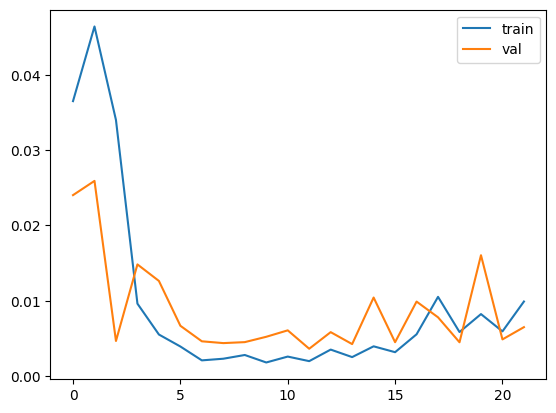

4/4 [==============================] - 0s 3ms/step
mae: 1.4351988232770647


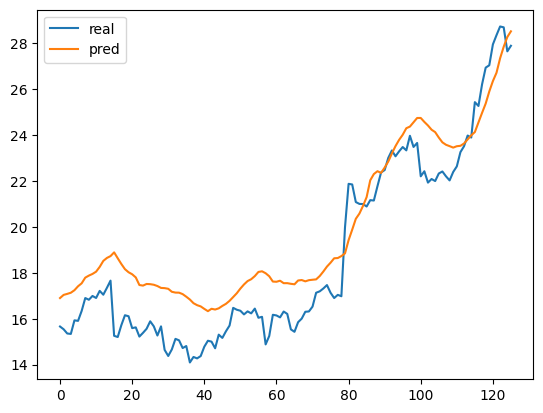

Epoch 1/1000
29/29 [==============================] - 2s 31ms/step - loss: 0.0300 - val_loss: 0.0292
Epoch 2/1000
29/29 [==============================] - 1s 26ms/step - loss: 0.0301 - val_loss: 0.0376
Epoch 3/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0188 - val_loss: 0.0128
Epoch 4/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0113 - val_loss: 0.0082
Epoch 5/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 6/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 7/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0055 - val_loss: 0.0137
Epoch 8/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 9/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 10/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0055 - val_lo

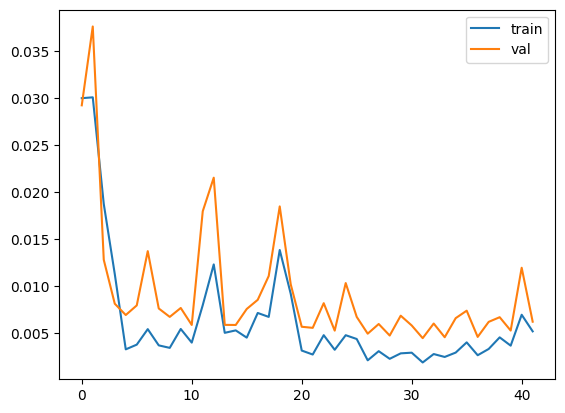

4/4 [==============================] - 0s 3ms/step
mae: 2.2241737828688852


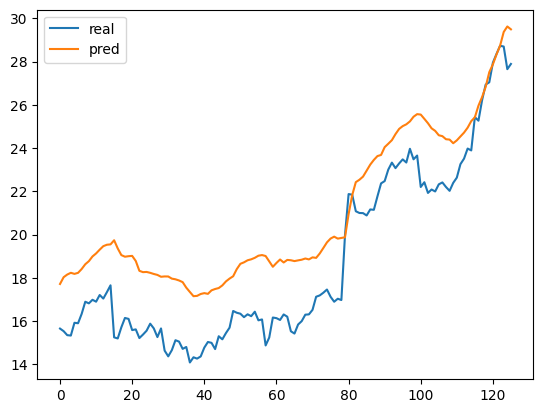

Epoch 1/1000
32/32 [==============================] - 2s 30ms/step - loss: 0.0486 - val_loss: 0.0042
Epoch 2/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.0130 - val_loss: 0.0036
Epoch 3/1000
32/32 [==============================] - 1s 25ms/step - loss: 0.0252 - val_loss: 0.0231
Epoch 4/1000
32/32 [==============================] - 1s 25ms/step - loss: 0.0211 - val_loss: 0.0328
Epoch 5/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.0129 - val_loss: 0.0086
Epoch 6/1000
32/32 [==============================] - 1s 25ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 7/1000
32/32 [==============================] - 1s 25ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 8/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 9/1000
32/32 [==============================] - 1s 25ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 10/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.0060 - val_lo

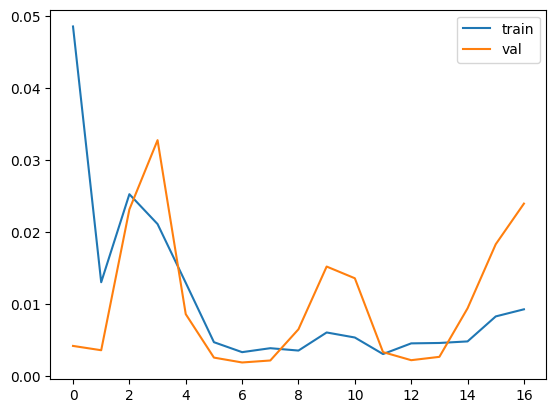

4/4 [==============================] - 0s 3ms/step
mae: 2.751699895873055


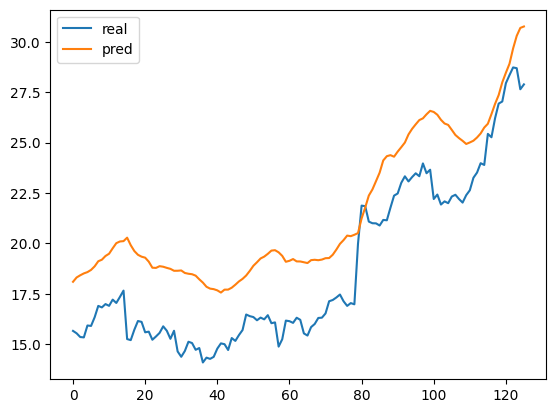

In [22]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
y_test=np.repeat(y_test,X_train.shape[2],axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_t, X_v = X_train[train_index],X_train[val_index]
    y_t, y_v = y_train[train_index], y_train[val_index]
    model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_t,y_t,epochs=1000,validation_data=(X_v,y_v),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,X_train.shape[2],axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


In [23]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 160)               62720     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 161       
                                                                 
Total params: 62881 (245.63 KB)
Trainable params: 62881 (245.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
average_mae=np.mean(maes)

print('average mae:',average_mae)

average mae: 1.9682117959059944
